In [2]:
# useful libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import pandas as pd
from pandas.plotting import lag_plot
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
import math

In [4]:
# code to parse the .vec files
def parse_directory(directory):
    def parse_vec_file(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        vector_map = {}
        vector_pattern = re.compile(r'vector (\d+) (.+?) (delayStat:vector|queueingTime:vector) ETV')
        value_pattern = re.compile(r'(\d+)\s+(\d+)\s+([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s+([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)')

        for line in lines:
            vector_match = vector_pattern.match(line)
            if vector_match:
                vector_id, vector_source, vector_type = vector_match.groups()
                vector_map[vector_id] = vector_type

        delay_stat_values = []
        queueing_time_values = []

        for line in lines:
            value_match = value_pattern.match(line)
            if value_match:
                vector_id, event_number, timestamp, value = value_match.groups()
                if vector_id in vector_map:
                    if vector_map[vector_id] == "delayStat:vector":
                        delay_stat_values.append((vector_id, event_number, timestamp, value))
                    elif vector_map[vector_id] == "queueingTime:vector":
                        queueing_time_values.append((vector_id, event_number, timestamp, value))

        delay_stat_df = pd.DataFrame(delay_stat_values, columns=['VectorID', 'EventNumber', 'Timestamp', 'Value'])
        queueing_time_df = pd.DataFrame(queueing_time_values, columns=['VectorID', 'EventNumber', 'Timestamp', 'Value'])

        return {'delayStat': delay_stat_df, 'queueingTime': queueing_time_df}

    all_dataframes = {}

    for filename in os.listdir(directory):
        if filename.endswith(".vec"):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                parsed_data = parse_vec_file(file_path)
                all_dataframes[filename] = parsed_data

    return all_dataframes



In [19]:
def preprocess_data(file_name):
    data = pd.read_csv(file_name)
    df = pd.DataFrame(data)
    
    for column in ['vectime', 'vecvalue']:
        df[column] = df[column].str.replace(' +', ',', regex=True)
        df[column] = df[column].apply(lambda x: [float(i) for i in ast.literal_eval(x)])

    return df['vectime'][0], df['vecvalue'][0], df['vectime'][1], df['vecvalue'][1]

In [20]:
def compute_lognormal(data):
    for i in data:
        meanSexp = 1/i
        varSexp = 1/(i**2)

        meanSlog = math.log(meanSexp**2/(math.sqrt(varSexp+meanSexp**2)))
        varSlog = math.sqrt(math.log(varSexp/(meanSexp**2)+1))

        print("MEANSLOG ",i,": ",meanSlog)
        print("VARSLOG ",i,": ",varSlog)
        print(" ")


In [12]:
# PLOTTING THE COMPARISON BETWEEN THE END-TO-END DELAY AND THE QUEUEING TIME
def plot_comparison(dfs, log):
    plt.rcParams.update({
        'axes.titlesize': 20,     
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,    
    })

    cells = [5, 10, 15, 20]
    compressions = [0, 10, 20, 30]
    colors = [(0.2, 0.4, 0.8, 0.6), (1.0, 0.4, 0.4, 0.6), (1.0, 0.6, 0.2, 0.6), (0.4, 0.8, 0.4, 0.6)] 
    lamdat = [10, 50, 100]

    variableS = []

    if(log == 0):
        variableS = [0.01, 0.005]
    else:
        variableS = [4.258596595708119, 4.9517437762680645]

    for s in variableS:
        for t in lamdat:
            fig, ax = plt.subplots(figsize=(14, 8))
            
            bar_width = 0.2
            bar_positions = np.arange(len(cells))
            
            # Collect the data
            all_means = {c: [] for c in compressions}
            all_means1 = {c: [] for c in compressions}
            all_ratios = {c: [] for c in compressions}
            for c in compressions:
                for n in cells:
                    tmp_means = []
                    tmp_means1 = []
                    for i in range(30):
                        if(log == 0):
                            df_target = dfs[f'test100k-N={n},M=12500,lamdaS={s},lamdaT={t},test=1,PC={c}-#{i}.vec']['delayStat']['Value']
                            df_target1 = dfs[f'test100k-N={n},M=12500,lamdaS={s},lamdaT={t},test=1PC={c}-#{i}.vec']['queueingTime']['Value']
                        else:
                            df_target = dfs[f'testlog100k-N={n},M=12500,mediaS={s},lamdaT={t},test=1,PC={c}-#{i}.vec']['delayStat']['Value']
                            df_target1 = dfs[f'testlog100k-N={n},M=12500,mediaS={s},lamdaT={t},test=1,PC={c}-#{i}.vec']['queueingTime']['Value']
                        mean_val = (pd.Series([float(x) for x in df_target]).mean())  
                        mean_val1 = (pd.Series([float(x) for x in df_target1]).mean())
                        tmp_means.append(mean_val)
                        tmp_means1.append(mean_val1)
                    mean_val = np.mean(tmp_means)
                    mean_val1 = np.mean(tmp_means1)
                    all_means[c].append(mean_val)
                    all_means1[c].append(mean_val1)
                    all_ratios[c].append((mean_val1 / mean_val) * 100)
            
            for idx, c in enumerate(compressions):
                positions = bar_positions + idx * bar_width
                ax.bar(positions, all_means[c], width=bar_width, color=colors[idx], label=f'End-to-end delay (PC={c})', capsize=5)
                ax.bar(positions, all_means1[c], width=bar_width, color=colors[idx], alpha=0.5, label=f'Queueing time (PC={c})', hatch='//', capsize=5)
            
            ax.set_xlabel('Number of cells')
            ax.set_ylabel('Time [s]')
            ax.set_title(f'Comparison of End-to-End Delay and Queueing Time (lamdaS={s}, lamdaT={t})')
            ax.set_xticks(bar_positions + bar_width * (len(compressions) - 1) / 2)
            ax.set_xticklabels(cells)
            plt.legend()
            plt.tight_layout()
            plt.grid(True)
            if(log == 0):
                plt.savefig(f'plots/comparison_exp_lamdaS={s}_lamdaT={t}.png')
            else:
                plt.savefig(f'plots/comparison_log_lamdaS={s}_lamdaT={t}.png')
            plt.show()    

In [13]:
def plot_delay(dfs, log):
    plt.rcParams.update({
        'axes.titlesize': 20,     
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
    })

    cells = [5, 10, 15, 20]
    compressions = [0, 10, 20, 30]
    colors = [(0.2, 0.4, 0.8, 0.6), (1.0, 0.4, 0.4, 0.6), (1.0, 0.6, 0.2, 0.6), (0.4, 0.8, 0.4, 0.6)]  
    lamdat = [10, 50, 100]
    variableS = []

    if(log == 0):
        variableS = [0.01, 0.005]
    else:
        variableS = [4.258596595708119, 4.9517437762680645]

    for s in variableS:
        for t in lamdat:
            fig, ax = plt.subplots(figsize=(14, 8))
            
            bar_width = 0.2
            bar_positions = np.arange(len(cells))
            
            # Collect the data
            for c in compressions:
                all_means = []
                all_cis = []
                for n in cells:
                    tmp_means = []
                    for i in range(30):
                        if(log == 0):
                            df_target = dfs[f'test100k-N={n},M=12500,lamdaS={s},lamdaT={t},test=1,PC={c}-#{i}.vec']['delayStat']['Value']
                        else:
                            df_target = dfs[f'testlog100k-N={n},M=12500,mediaS={s},lamdaT={t},test=1,PC={c}-#{i}.vec']['delayStat']['Value']
                        # lag plot singola iterazione
                        # lag_plot(pd.Series([float(x) for x in df_target]))
                        # plt.show()
                        tmp_means.append((pd.Series([float(x) for x in df_target]).mean()))
                    # lag plot tra le medie
                    # lag_plot(pd.Series(tmp_means))
                    # plt.show()
                    # qq plot tra le medie
                    # qqplot(pd.Series(tmp_means), line='s')
                    # plt.show()
                    mean_val = np.mean(tmp_means)
                    ci = 1.96 * np.std(tmp_means) / np.sqrt(len(tmp_means))  
                    all_means.append(mean_val)
                    all_cis.append(ci)
                if(c == 0):
                    positions = bar_positions + 0 * bar_width
                    ax.bar(positions, all_means, yerr=all_cis, width=bar_width, color=colors[0], label=f'PC={c}', capsize=5)
                elif c == 10:
                    positions = bar_positions + 1 * bar_width
                    ax.bar(positions, all_means, yerr=all_cis, width=bar_width, color=colors[1], label=f'PC={c}', capsize=5)
                elif c == 20:
                    positions = bar_positions + 2 * bar_width
                    ax.bar(positions, all_means, yerr=all_cis, width=bar_width, color=colors[2], label=f'PC={c}', capsize=5)
                else:
                    positions = bar_positions + 3 * bar_width
                    ax.bar(positions, all_means, yerr=all_cis, width=bar_width, color=colors[3], label=f'PC={c}', capsize=5)
            ax.set_xlabel('Number of cells')
            ax.set_ylabel('Mean end-to-end delay (s)')
            ax.set_title(f'Mean end-to-end delay for different PC values with 95% CI (lamdaS={s}, lamdaT={t})')
            ax.set_xticks(bar_positions + bar_width * (len(compressions) - 1) / 2)
            ax.set_xticklabels(cells)
            plt.legend()
            plt.tight_layout()
            plt.grid(True)
            if(log == 0):
                plt.savefig(f'plots/delay_exp_lamdaS={s}_lamdaT={t}.png')
            else:
                plt.savefig(f'plots/delay_log_lamdaS={s}_lamdaT={t}.png')
            plt.show()


In [44]:
def estimate_warmup(dfs):
    plt.figure(figsize=(20, 6))
    plt.rcParams.update({
        'axes.titlesize': 20,     
        'axes.labelsize': 16,     
    })
    
    timestamps = [60, 80, 100, 120, 140, 160]
    means_at_timestamps = {timestamp: [] for timestamp in timestamps}
    
    for i in range(30):
        df_target = dfs['warmup-M=12500,test=1,PC=20-#' + str(i) + '.vec']['delayStat']['Value']
        df_simtime = dfs['warmup-M=12500,test=1,PC=20-#' + str(i) + '.vec']['delayStat']['Timestamp']

        # df_target = dfs['simtime-M=12500,test=1,PC=20-#' + str(i) + '.vec']['delayStat']['Value']
        # df_simtime = dfs['simtime-M=12500,test=1,PC=20-#' + str(i) + '.vec']['delayStat']['Timestamp
        
        temp_sum = 0
        means = []
        number = 0
        
        for row, simtime in zip(df_target, df_simtime):
            temp_sum += float(row)
            number += 1
            temp_mean = temp_sum / number
            means.append((float(simtime), temp_mean))
        
        for timestamp in timestamps:
            closest_mean = None
            for simtime, mean in means:
                if simtime >= timestamp:
                    closest_mean = mean
                    break
            if closest_mean is not None:
                means_at_timestamps[timestamp].append(closest_mean)
        
        plt.plot([simtime for simtime, mean in means], [mean for simtime, mean in means])
    
    plt.grid(True)
    plt.xlabel('Simulation time [s]')
    plt.ylabel('Mean end-to-end delay [s]')
    plt.title('Mean end-to-end delay over simulation time')
    plt.xticks(np.arange(0, 161, 20))
    plt.savefig('plots/warmuplognormal.png')
    plt.show()
    
    for timestamp in timestamps:
        means_list = means_at_timestamps[timestamp]
        if means_list: 
            overall_mean = np.mean(means_list)
            std_dev = np.std(means_list, ddof=1)
            print(f'Timestamp: {timestamp}s')
            print(f'Mean of means: {overall_mean*1000}ms')
            print(f'Sample standard deviation: {std_dev*1000}ms')
        else:
            print(f'Timestamp: {timestamp}s')
            print('No data available')
            print()

In [28]:
lamdaSexp = [0.01, 0.005, 0.002, 0.001]
compute_lognormal(lamdaSexp)

MEANSLOG  0.01 :  4.258596595708119
VARSLOG  0.01 :  0.8325546111576977
 
MEANSLOG  0.005 :  4.9517437762680645
VARSLOG  0.005 :  0.8325546111576977
 
MEANSLOG  0.002 :  5.868034508142219
VARSLOG  0.002 :  0.8325546111576977
 
MEANSLOG  0.001 :  6.561181688702164
VARSLOG  0.001 :  0.8325546111576977
 


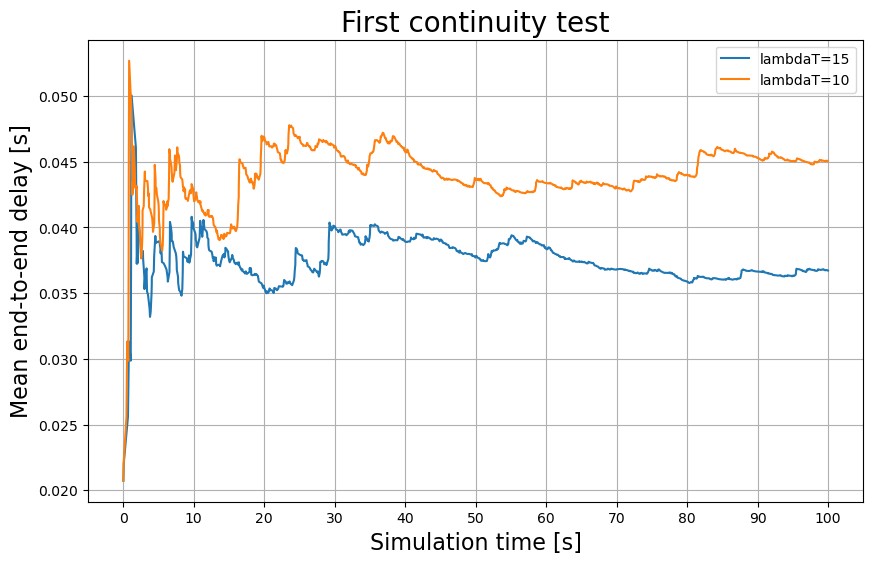

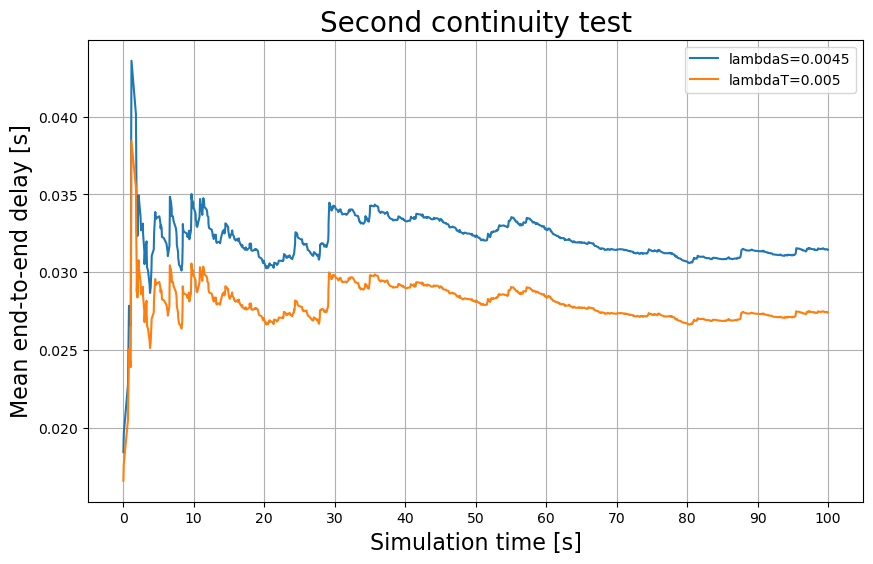

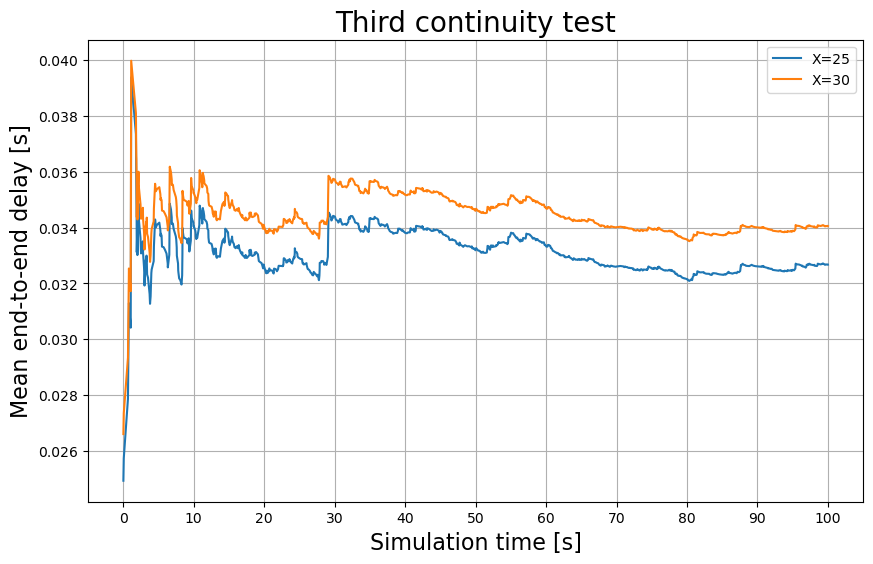

In [31]:
# continuity test 1
a, b, c, d = preprocess_data('continuity1.csv')

plt.figure(figsize=(10,6))

plt.rcParams.update({
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 16,     # Axis label font size
})

plt.plot(a, b, label="lambdaT=15")
plt.plot(c, d, label="lambdaT=10")
plt.xticks(np.arange(0, 101, 10))
plt.xlabel("Simulation time [s]")
plt.ylabel("Mean end-to-end delay [s]")
plt.title("First continuity test")
plt.legend()
plt.grid(True)
plt.savefig("plots/continuity1.png")
plt.show()

# continuity test 2
a, b, c, d = preprocess_data('continuity2csv.csv')

plt.figure(figsize=(10,6))

plt.plot(a, b, label="lambdaS=0.0045")
plt.plot(c, d, label="lambdaT=0.005")
plt.xticks(np.arange(0, 101, 10))
plt.xlabel("Simulation time [s]")
plt.ylabel("Mean end-to-end delay [s]")
plt.title("Second continuity test")
plt.legend()
plt.grid(True)
plt.savefig("plots/continuity2.png")
plt.show()

# continuity test 3
a, b, c, d = preprocess_data('continuity3csv.csv')

plt.figure(figsize=(10,6))

plt.plot(a, b, label="X=25")
plt.plot(c, d, label="X=30")
plt.xticks(np.arange(0, 101, 10))
plt.xlabel("Simulation time [s]")
plt.ylabel("Mean end-to-end delay [s]")
plt.title("Third continuity test")
plt.legend()
plt.grid(True)
plt.savefig("plots/continuity3.png")
plt.show()

In [ ]:
dfs = parse_directory('results')

In [ ]:
plot_delay(dfs, 0)

In [ ]:
plot_comparison(dfs, 0)

In [ ]:
plot_delay(dfs, 1)

In [ ]:
plot_comparison(dfs, 1)

In [ ]:
estimate_warmup(dfs)

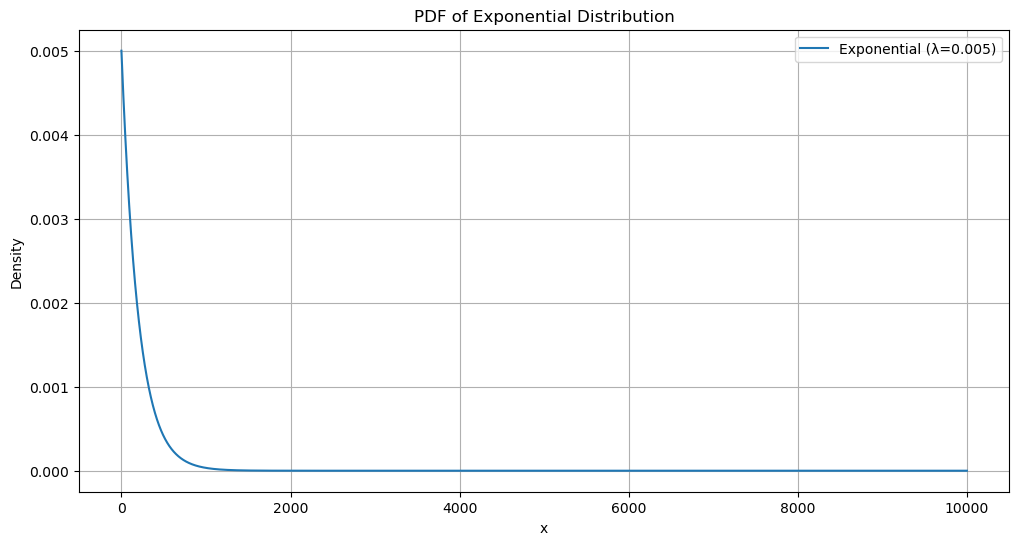

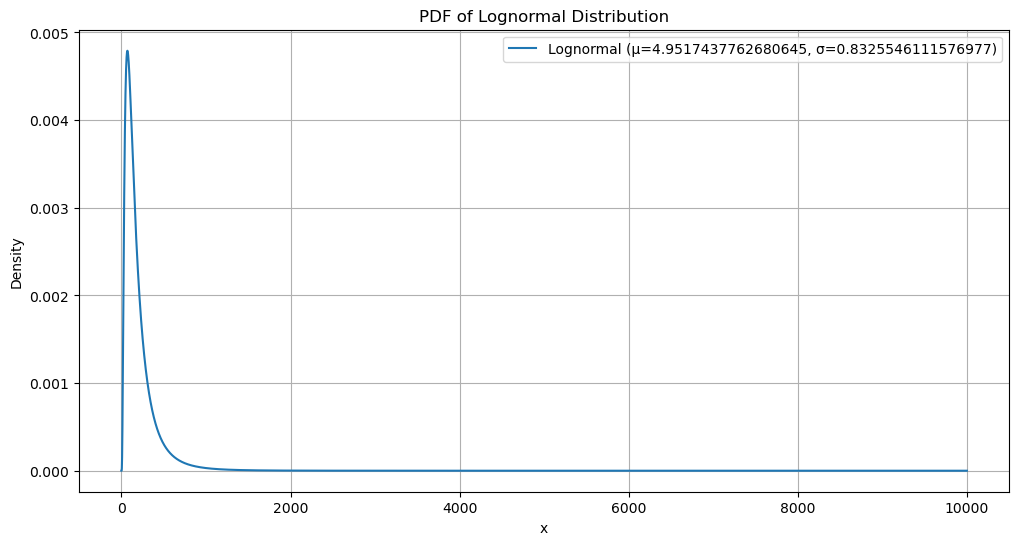

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, expon

def plot_pdf_exponential(lamda, x_range):
    pdf_exponential = expon.pdf(x_range, scale=1/lamda)
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_range, pdf_exponential, label=f'Exponential (λ={lamda})')
    plt.title('PDF of Exponential Distribution')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pdf_lognormal(mu, sigma, x_range):
    pdf_lognormal = lognorm.pdf(x_range, s=sigma, scale=np.exp(mu))
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_range, pdf_lognormal, label=f'Lognormal (μ={mu}, σ={sigma})')
    plt.title('PDF of Lognormal Distribution')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

x_range = np.linspace(0.01, 10000, 10000)

lamda = 0.005
plot_pdf_exponential(lamda, x_range)

mu = 4.9517437762680645
sigma = 0.8325546111576977
plot_pdf_lognormal(mu, sigma, x_range)


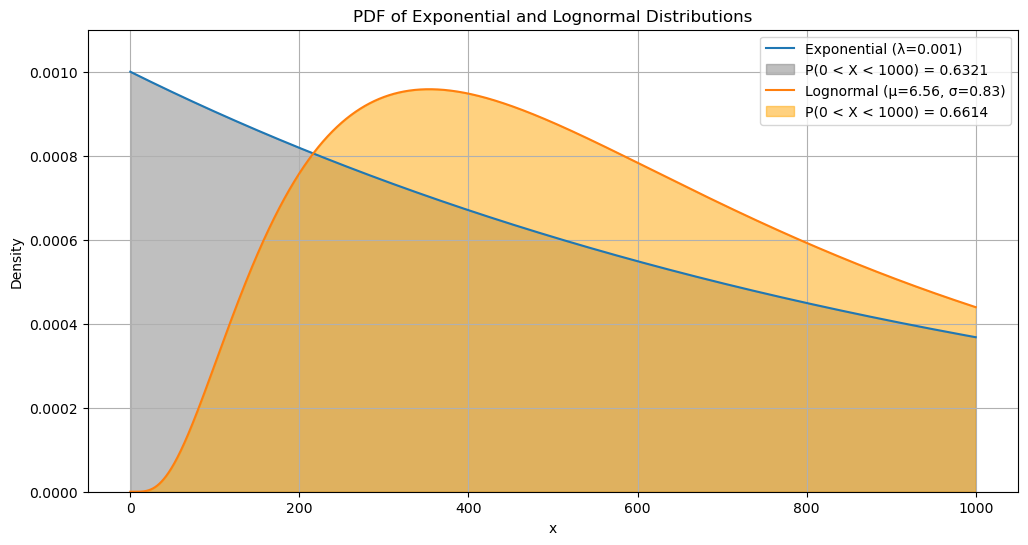

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, expon

def plot_pdf_combined(lamda, mu, sigma, x_range, a_exp, b_exp, a_log, b_log):
    pdf_exponential = expon.pdf(x_range, scale=1/lamda)
    
    pdf_lognormal = lognorm.pdf(x_range, s=sigma, scale=np.exp(mu))
    
    pdf_at_a_exp = expon.pdf(a_exp, scale=1/lamda)
    pdf_at_a_log = lognorm.pdf(a_log, s=sigma, scale=np.exp(mu))
    
    prob_exp = expon.cdf(b_exp, scale=1/lamda) - expon.cdf(a_exp, scale=1/lamda)
    prob_log = lognorm.cdf(b_log, s=sigma, scale=np.exp(mu)) - lognorm.cdf(a_log, s=sigma, scale=np.exp(mu))
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(x_range, pdf_exponential, label=f'Exponential (λ={lamda})')
    
    plt.fill_between(x_range, pdf_exponential, alpha=0.5, color='gray', 
                     where=(x_range >= a_exp) & (x_range <= b_exp),
                     label=f'P({a_exp} < X < {b_exp}) = {prob_exp:.4f}')
    
    plt.plot(x_range, pdf_lognormal, label=f'Lognormal (μ={mu:.2f}, σ={sigma:.2f})')
    
    plt.fill_between(x_range, pdf_lognormal, alpha=0.5, color='orange', 
                     where=(x_range >= a_log) & (x_range <= b_log),
                     label=f'P({a_log} < X < {b_log}) = {prob_log:.4f}')
    
    plt.ylim(0, max(1.1 * pdf_at_a_exp, 1.1 * pdf_at_a_log))
    
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('PDF of Exponential and Lognormal Distributions')
    plt.grid(True)
    plt.legend()
    
    plt.show()

# Example usage
x_range_exp = np.linspace(a_exp, b_exp, 10000)  # Define the range of x values for exponential distribution
x_range_log = np.linspace(a_log, b_log, 10000)  # Define the range of x values for lognormal distribution

# Parameters for exponential distribution
lamda = 0.005
a_exp, b_exp = 0, 1000  # Define the interval [a_exp, b_exp]

# Parameters for lognormal distribution
mu = 4.9517437762680645
sigma = 0.8325546111576977
a_log, b_log = 0, 1000  # Define the interval [a_log, b_log]

# Call the function to plot both distributions on a single figure
plot_pdf_combined(lamda, mu, sigma, x_range_exp, a_exp, b_exp, a_log, b_log)
